In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Load and Clean Data

In [2]:
building_raw = pd.read_csv('building_fire_risk.csv')
demo_raw = pd.read_csv('demographic_data/nyc_demographic_data.csv')
eco_raw = pd.read_csv('nyc_economic_data.csv')
fire_inc_all_raw = pd.read_csv('FireIncidenceAll.csv')
fire_inc_high_raw = pd.read_csv('HighRiskData.csv')
fire_inc_low_raw = pd.read_csv('LowRiskData.csv')

#### Demographic data (demo)

In [3]:
# Remove 'Total_Language_Population' column because all values are NaN and
# 'Median_Year_Built' because data is already captured in building data
demo = demo_raw.drop(['Total_Language_Population', 'Median_Year_Built'], axis=1)
demo.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,Not_in_Labor_Force,Employed,Unemployed,Median_Travel_Time,Total_With_Disability,No_Health_Insurance,Vehicles_Available,Foreign_Born,Median_Earnings,Households_with_Broadband
38,10128,57993,40.9,25068,32925,44069,2644,24,5364,0,...,36034,36034,1592,29859,57974,0,29698,13757,88584,27266
56,10454,37807,31.6,18236,19571,6264,13164,256,108,44,...,15237,15226,1886,12389,37756,0,13573,10931,27007,9207
36,10040,45197,38.5,21432,23765,14944,4055,405,1293,0,...,24117,24117,3141,17980,43885,0,16100,21329,35638,13984
139,11373,96495,37.8,47161,49334,15131,1702,655,47947,27,...,52889,52889,2351,46289,96081,0,31255,63938,31439,26664
39,10280,9372,43.3,4983,4389,7129,55,130,1710,0,...,6372,6372,145,5394,9372,0,4524,2618,126291,4412


#### Building data (building)

In [4]:
# Assign risks to each zipcode
# high risk: 5, medium risk: 3, low risk: 1
building = building_raw.copy()
building = building.replace({'high':3, 'medium':2, 'low':1})

# Calculate total risk per zipcode
building['total_risk'] = building['risk'] * building['count']
build_risks = building.groupby('zipcode').sum()['total_risk']
building = building.merge(build_risks, on='zipcode', how='left').drop(['risk', 'count', 'total_risk_x'], axis=1).rename({'total_risk_y':'total_risk'}, axis=1)
building.drop_duplicates(inplace=True)

# Assign area_mile2 to zipcodes without value. Use minimum area_mile2 / 2
new_area_mile2 = building_raw.area_mile2.min() / 2
building.area_mile2 = building.area_mile2.fillna(new_area_mile2)

# Calculate average risk per zipcode
building['avg_build_risk'] = building.apply(lambda x: round(x['total_risk'] / x['area_mile2'], 3), axis=1)

# Keep useful columns and rename zipcode to ZIP to be consistent with other datasets
building = building[['zipcode', 'avg_build_risk']].rename({'zipcode': 'ZIP'}, axis=1)

building.sample(5)

C:\Users\kevin\AppData\Local\Temp\ipykernel_31904\2515830439.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  building = building.replace({'high':3, 'medium':2, 'low':1})


,ZIP,avg_build_risk
307,11106,10957.188
594,12345,7191.083
118,10055,958.811
343,11212,12268.252
153,10175,1438.217


#### Economic data (eco)

In [5]:
eco = eco_raw.copy()
# Extract useful columns
eco = eco[['ZIP', 'est_households_total', 'est_households_median_income_dollars', 'est_households_mean_income_dollars', 
          'est_families_total', 'est_families_median_income_dollars', 'est_families_mean_income_dollars', 
          'est_married_couple_families_total', 'est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars',
          'est_nonfamily_households_total', 'est_nonfamily_households_median_income_dollars', 'est_nonfamily_households_mean_income_dollars']]
eco.sample(5)

,ZIP,est_households_total,est_households_median_income_dollars,est_households_mean_income_dollars,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars
76,10474,3917,41279.0,58859,2551,47625.0,67132,772,87643.0,NaN,1366,30867,36080
65,10463,29575,72952.0,101956,16495,84178.0,122236,9096,126204.0,NaN,13080,56527,73152
134,11366,4518,117402.0,138075,3291,133779.0,156783,2727,134522.0,NaN,1227,62330,78927
2,10003,25080,153750.0,248577,6847,NaN,416996,5896,NaN,NaN,18233,117570,184364
5,10006,2305,209972.0,235292,792,NaN,329790,632,NaN,NaN,1513,150609,185827


#### Fire Incident Data

In [6]:
# Extract useful columns
fire_inc_all = fire_inc_all_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'all_incident'}, axis=1)
fire_inc_low = fire_inc_low_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'low_incident'}, axis=1)
fire_inc_high = fire_inc_high_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'high_incident'}, axis=1)

In [7]:
# Combine all data and calculate medium risk incidents
inc = fire_inc_all.merge(fire_inc_low, on='ZIP', how='left')
inc = inc.merge(fire_inc_high, on='ZIP', how='left')
inc['med_incident'] = inc['all_incident'] - inc['high_incident'] - inc['low_incident']
inc.drop('all_incident', inplace=True, axis=1)

In [8]:
# Assign risks to each zipcode
risk_factor = {'high':3, 'medium':2, 'low':1}
inc['fire_incident_risk'] = inc['high_incident'] * risk_factor['high'] \
                            + inc['med_incident'] * risk_factor['medium'] \
                            + inc['low_incident'] * risk_factor['low']
# Drop 'low_incident', 'med_incident', 'high_incident' columns
inc = inc[['ZIP', 'fire_incident_risk']]
inc.sample(5)

,ZIP,fire_incident_risk
147,11378,5816
114,11228,5750
101,11214,10958
161,11422,6166
169,11434,14101


# Combine Data

In [9]:
# demo + building = df
df = demo.merge(building, on='ZIP')

# df + eco = df
df = df.merge(eco, on='ZIP')

# df + inc = df
df = df.merge(inc, on='ZIP')

df.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars,fire_incident_risk
109,11226,96332,34.8,44002,52330,15139,64136,714,2826,0,...,22600,93381.0,122237,11753,120203.0,NaN,16705,63104,82425,21569
84,11109,6127,33.0,3106,3021,3534,91,0,2174,0,...,2036,227614.0,275797,1904,241389.0,NaN,1602,150000,200274,492
6,10007,7566,34.4,4152,3414,5784,623,0,882,0,...,1690,NaN,725328,1516,NaN,NaN,1619,210343,282549,3849
153,11692,22394,37.0,10930,11464,4666,12579,142,1245,0,...,5210,69754.0,108276,2451,123649.0,NaN,2771,28584,50287,3964
93,11210,62423,36.8,29528,32895,19856,35240,24,2369,0,...,14520,102857.0,133729,8725,123626.0,159290.0,6920,51126,72294,11621


# Prep Data for Model

In [10]:
df.isna().sum()

ZIP                                                    0
Total_Population                                       0
Median_Age                                             0
Male_Population                                        0
Female_Population                                      0
White                                                  0
Black                                                  0
American_Indian_Alaska_Native                          0
Asian                                                  0
Native_Hawaiian_Pacific_Islander                       0
Other_Race                                             0
Two_or_More_Races                                      0
Median_Household_Income                                0
Poverty_Total                                          0
Below_Poverty                                          0
Total_Educ_25plus                                      0
Bachelor_Degree                                        0
Advanced_Degree                

In [11]:
# Remove 'est_married_couple_families_median_income_dollars' and 
# 'est_married_couple_families_mean_income_dollars' column because 141 and 22 rows are NA's
df.drop(['est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars']
        , axis=1, inplace=True)

In [12]:
# est_households_median_income_dollars: 2 NA's
# Use avg ratio of est_households_median_income_dollars and est_households_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_households_median_income_dollars / df.est_households_mean_income_dollars)
df.est_households_median_income_dollars = df.est_households_median_income_dollars.fillna(df.est_households_mean_income_dollars * ratio)
# est_families_median_income_dollars: 14 NA's
# Use avg ratio of est_families_median_income_dollars and est_families_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_families_median_income_dollars / df.est_families_mean_income_dollars)
df.est_families_median_income_dollars = df.est_families_median_income_dollars.fillna(df.est_families_mean_income_dollars * ratio)


In [16]:
train_data = df.sample(frac=0.75, random_state=6242)
test_data = df.drop(train_data.index)
X_train = train_data.drop(['ZIP', 'fire_incident_risk'], axis=1)
y_train = train_data['fire_incident_risk']
X_test = test_data.drop(['ZIP', 'fire_incident_risk'], axis=1)
y_test = test_data['fire_incident_risk']

In [17]:
# Normalize data
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# DNN Prediction Model

In [18]:
def build_and_compile_model(norm, n_hidden, n_nodes):
    model = Sequential([norm])
    for i in range(n_hidden):
        model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',
                optimizer=Adam(0.001))
    return model

In [23]:
# Optimal number of layers
all_r2s = []
n_hidden = [15, 20, 25, 30]
n_nodes = [10, 20, 30, 40, 50, 60]
for n_node in n_nodes:
    r2 = []
    for i in n_hidden:
        dnn_model = build_and_compile_model(normalizer, i, n_node)
        dnn_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
        r2.append(metrics.r2_score(y_test, dnn_model.predict(X_test).flatten()))
    all_r2s.append(r2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


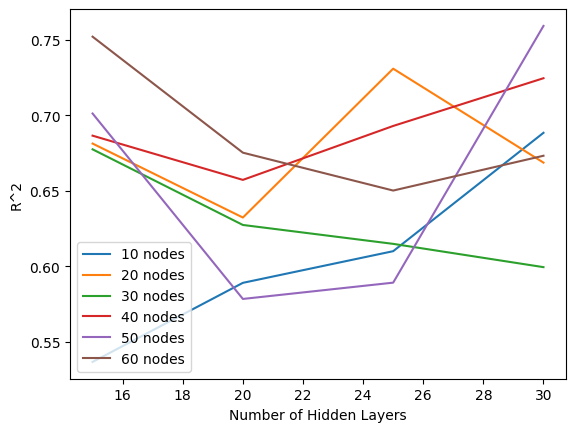

In [32]:
for r in range(len(all_r2s)):
    plt.plot(n_hidden, all_r2s[r], label=str(n_nodes[r]) + ' nodes');
plt.legend();
plt.xlabel('Number of Hidden Layers');
plt.ylabel('R^2');

Model with 50 nodes and 30 hidden layers had the best performance measured by R^2

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


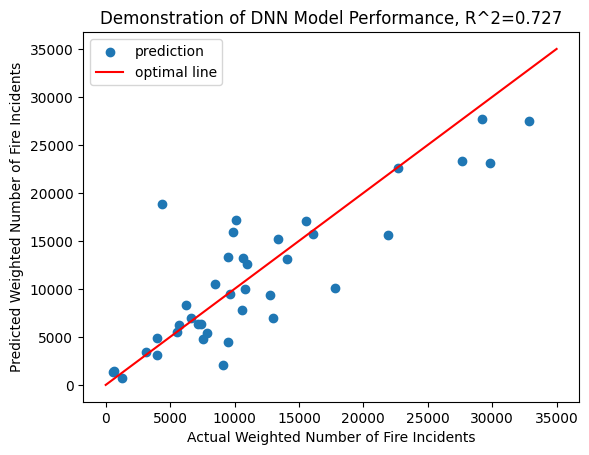

In [44]:
optimal_model = build_and_compile_model(normalizer, 30, 50)
optimal_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
R2 = round(metrics.r2_score(y_test, optimal_model.predict(X_test).flatten()), 3)
plt.scatter(y_test, optimal_model.predict(X_test).flatten(), label='prediction');
plt.plot([0, 35000], [0, 35000], color='red', label='optimal line');
plt.xlabel('Actual Weighted Number of Fire Incidents');
plt.ylabel('Predicted Weighted Number of Fire Incidents');
plt.title(f'Demonstration of DNN Model Performance, R^2={R2}');
plt.legend();